In [1]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report
import xgboost as xgb
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer
import numpy as np , pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load The Data
df = pd.read_csv('/kaggle/input/appendix-cancer-prediction-dataset/appendix_cancer_prediction_dataset.csv')
#droping ID and high null coloumns
df.drop(columns=['Patient_ID','Country'], inplace=True)

print('Data Frame: ')
df.head()

Data Frame: 


,Age,Gender,BMI,Smoking_Status,Alcohol_Consumption,Family_History_Cancer,Genetic_Mutations,Chronic_Diseases,Physical_Activity_Level,Diet_Type,...,Cholesterol_Level,White_Blood_Cell_Count,Red_Blood_Cell_Count,Platelet_Count,Tumor_Markers,Symptom_Severity,Diagnosis_Delay_Days,Treatment_Type,Survival_Years_After_Diagnosis,Appendix_Cancer_Prediction
0,67,Female,28.6,No,Low,Yes,No,Diabetes,High,Non-Vegetarian,...,228,8.1,4.4,361,Negative,Mild,691,Surgery,6.5,Yes
1,83,Female,19.4,No,Low,No,No,Diabetes,Low,Non-Vegetarian,...,186,9.7,6.2,235,Negative,Moderate,275,Chemotherapy,1.6,No
2,52,Female,17.2,No,Low,Yes,No,Diabetes,Low,Non-Vegetarian,...,231,8.2,4.6,269,Negative,Moderate,668,Chemotherapy,0.7,No
3,71,Male,31.8,Yes,Low,No,No,NaN,High,Non-Vegetarian,...,151,6.8,6.0,193,Negative,Moderate,256,Radiation,2.1,No
4,19,Female,17.7,No,Low,No,No,Hypertension,Moderate,Non-Vegetarian,...,236,6.7,4.9,396,Negative,Mild,370,Radiation,0.5,No


In [3]:
print("Dataset Information: ")
print(df.info())

print("Data Statistics: ")
df.describe()

Dataset Information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260000 entries, 0 to 259999
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Age                             260000 non-null  int64  
 1   Gender                          260000 non-null  object 
 2   BMI                             260000 non-null  float64
 3   Smoking_Status                  260000 non-null  object 
 4   Alcohol_Consumption             260000 non-null  object 
 5   Family_History_Cancer           260000 non-null  object 
 6   Genetic_Mutations               260000 non-null  object 
 7   Chronic_Diseases                129913 non-null  object 
 8   Physical_Activity_Level         260000 non-null  object 
 9   Diet_Type                       260000 non-null  object 
 10  Radiation_Exposure              260000 non-null  object 
 11  Previous_Cancers                260000 non-null  object 

,Age,BMI,Blood_Pressure,Cholesterol_Level,White_Blood_Cell_Count,Red_Blood_Cell_Count,Platelet_Count,Diagnosis_Delay_Days,Survival_Years_After_Diagnosis
count,260000.000000,260000.000000,260000.000000,260000.000000,260000.000000,260000.000000,260000.000000,260000.000000,260000.000000
mean,53.443331,24.996457,134.490342,224.477227,7.000596,4.999148,274.433846,365.181450,4.989499
std,20.750951,4.997116,25.961207,43.266553,1.496819,0.501531,72.207496,210.924211,4.976837
min,18.000000,1.100000,90.000000,150.000000,0.500000,2.800000,150.000000,0.000000,0.000000
25%,36.000000,21.600000,112.000000,187.000000,6.000000,4.700000,212.000000,182.000000,1.400000
50%,53.000000,25.000000,134.000000,224.000000,7.000000,5.000000,275.000000,366.000000,3.500000
75%,71.000000,28.400000,157.000000,262.000000,8.000000,5.300000,337.000000,548.000000,6.900000
max,89.000000,48.100000,179.000000,299.000000,13.700000,7.600000,399.000000,729.000000,67.800000


In [4]:
# fill the missed Data
df['Chronic_Diseases'] = df['Chronic_Diseases'].fillna(df['Chronic_Diseases'].mode()[0])
df['Treatment_Type'] = df['Treatment_Type'].fillna(df['Treatment_Type'].mode()[0])

In [5]:
#Spilt The Numerical And Categorical Columns
numerical_features = df.select_dtypes(include=['float64', 'int64'])
categorical_features = df.select_dtypes(include=['object']).columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260000 entries, 0 to 259999
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Age                             260000 non-null  int64  
 1   Gender                          260000 non-null  object 
 2   BMI                             260000 non-null  float64
 3   Smoking_Status                  260000 non-null  object 
 4   Alcohol_Consumption             260000 non-null  object 
 5   Family_History_Cancer           260000 non-null  object 
 6   Genetic_Mutations               260000 non-null  object 
 7   Chronic_Diseases                260000 non-null  object 
 8   Physical_Activity_Level         260000 non-null  object 
 9   Diet_Type                       260000 non-null  object 
 10  Radiation_Exposure              260000 non-null  object 
 11  Previous_Cancers                260000 non-null  object 
 12  Blood_Pressure  

In [7]:
#printing unique values numbers
for i in categorical_features:
    print(f'{df[i].value_counts()}\n')

Gender
Female    127597
Male      127170
Other       5233
Name: count, dtype: int64

Smoking_Status
No     182277
Yes     77723
Name: count, dtype: int64

Alcohol_Consumption
Low         130168
Moderate    103666
High         26166
Name: count, dtype: int64

Family_History_Cancer
No     207381
Yes     52619
Name: count, dtype: int64

Genetic_Mutations
No     233989
Yes     26011
Name: count, dtype: int64

Chronic_Diseases
Hypertension    207918
Diabetes         52082
Name: count, dtype: int64

Physical_Activity_Level
Low         103942
Moderate    103607
High         52451
Name: count, dtype: int64

Diet_Type
Non-Vegetarian    156349
Vegetarian         77879
Vegan              25772
Name: count, dtype: int64

Radiation_Exposure
No     246921
Yes     13079
Name: count, dtype: int64

Previous_Cancers
No     234075
Yes     25925
Name: count, dtype: int64

Tumor_Markers
Negative    208078
Positive     51922
Name: count, dtype: int64

Symptom_Severity
Mild        129761
Moderate     91197
S

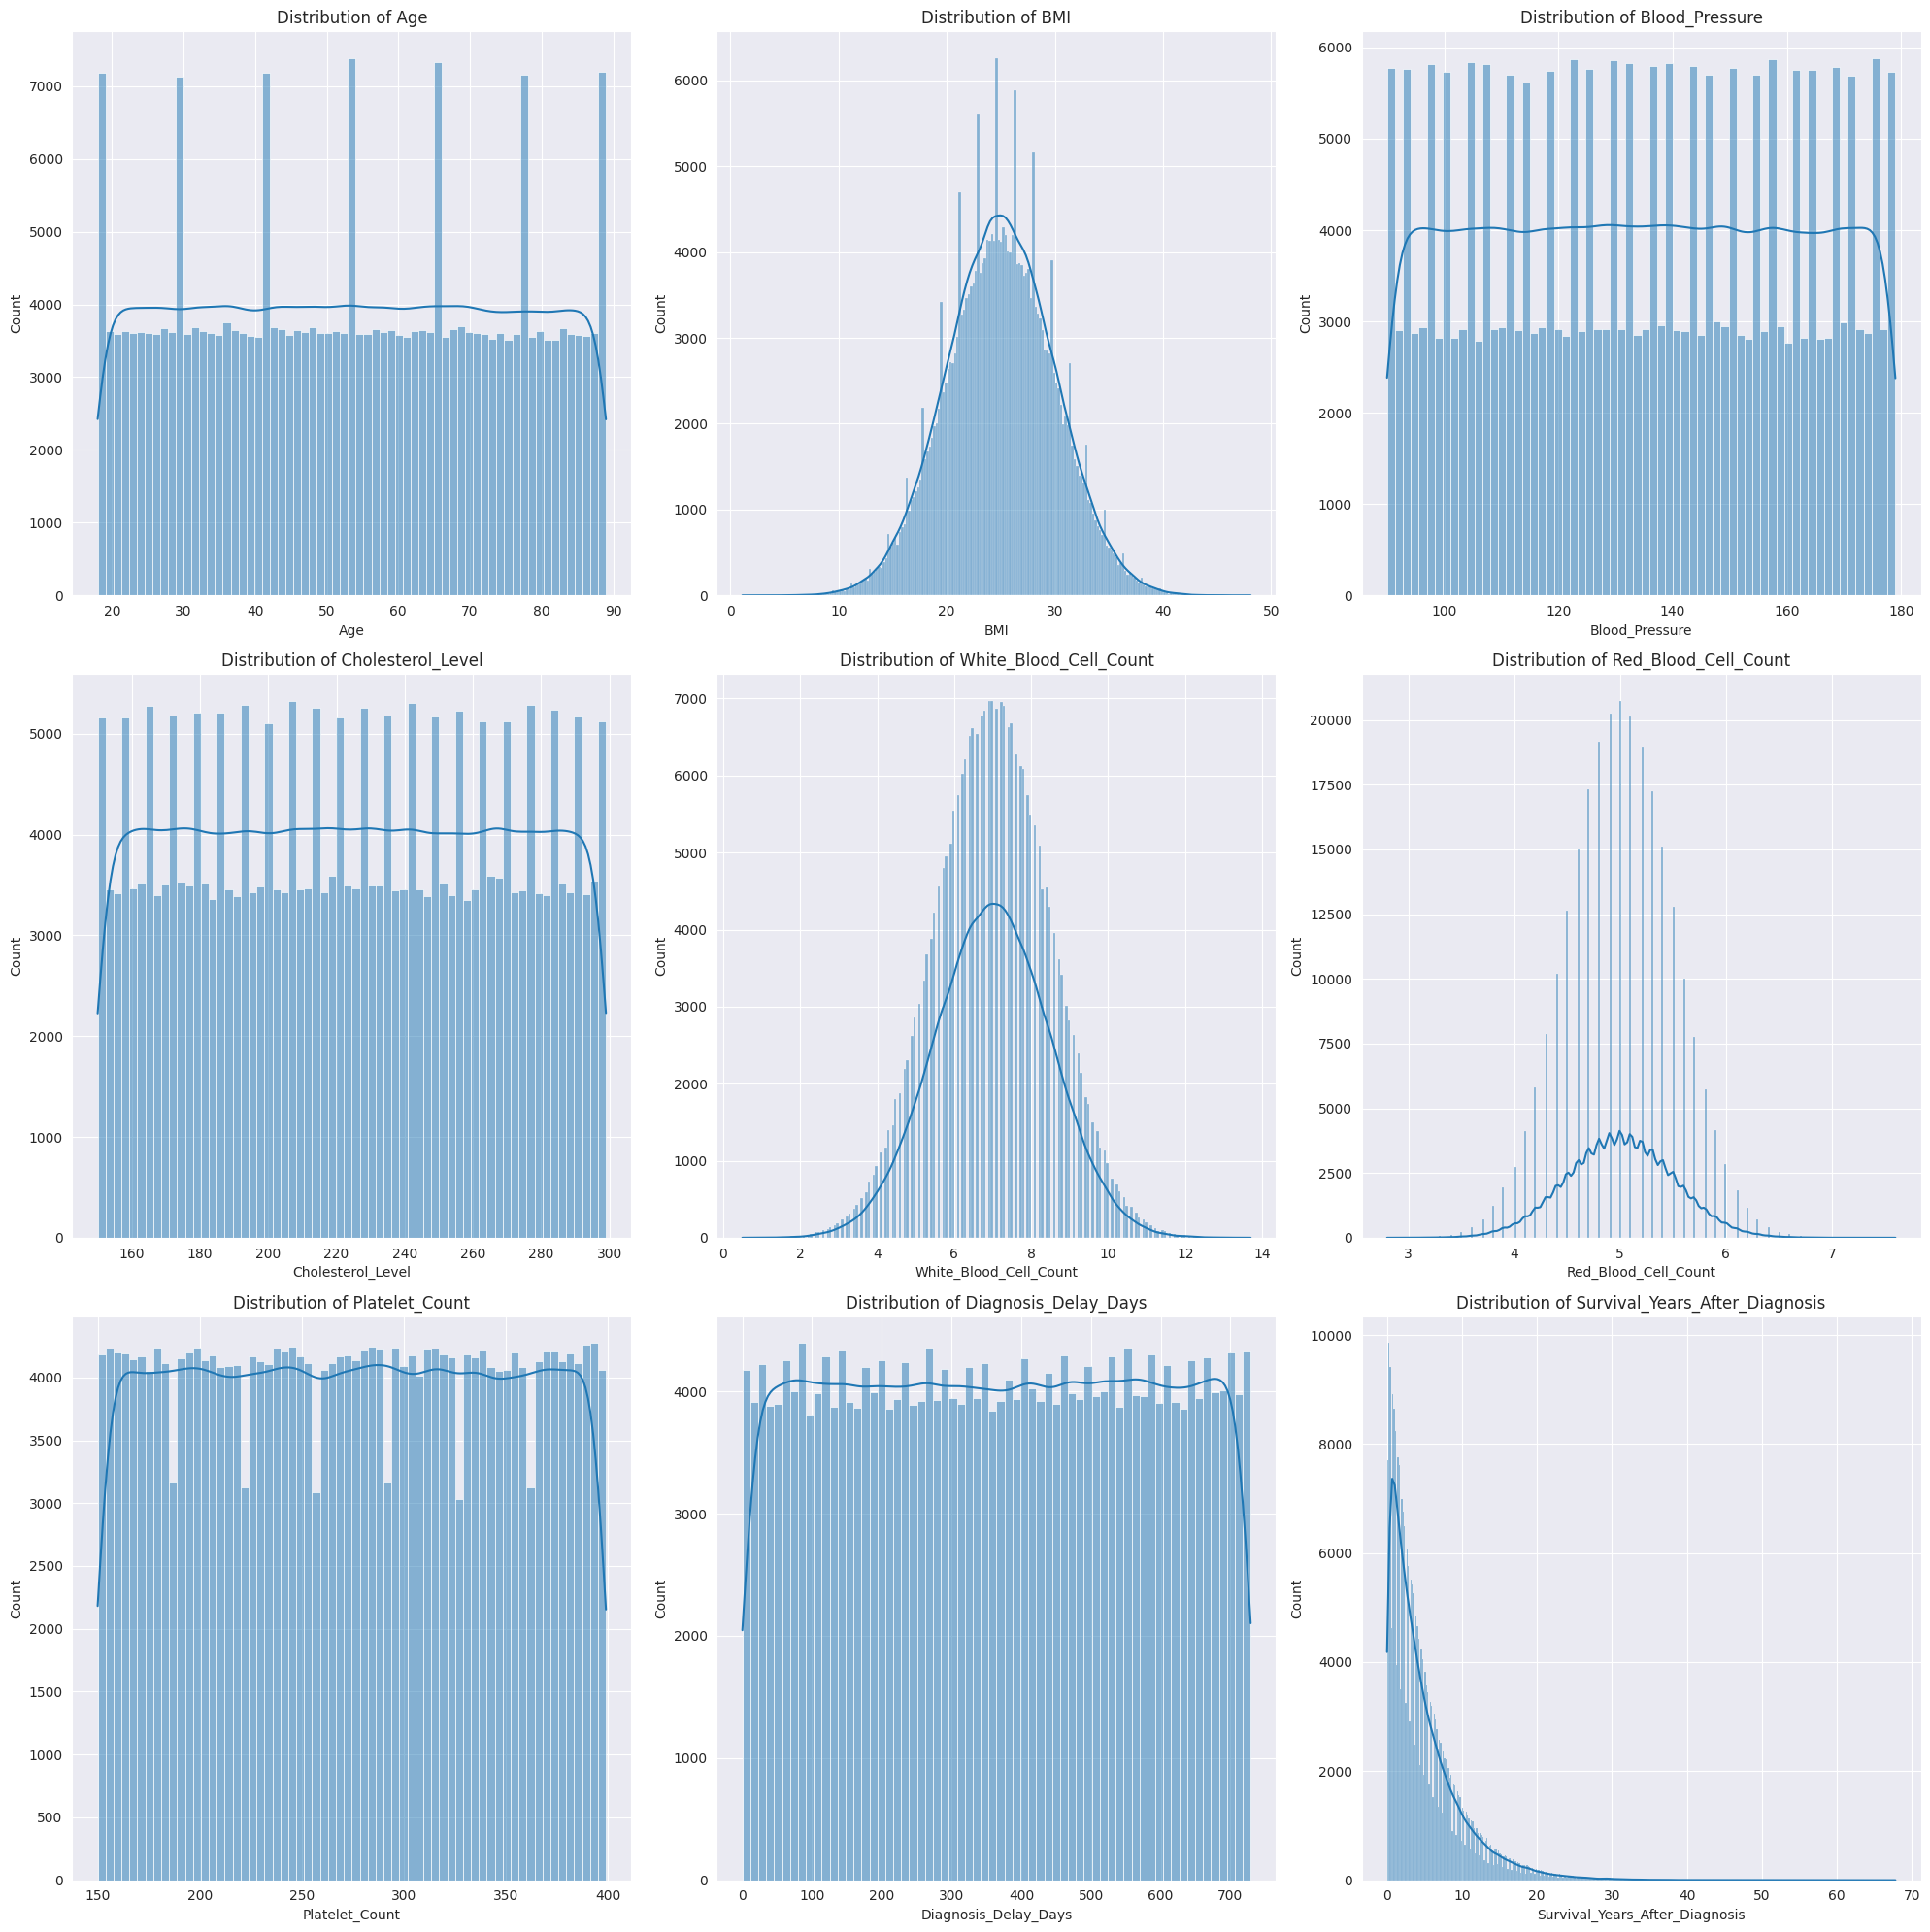

In [8]:
fig , ax = plt.subplots(3,3,figsize=(20,20))# 7 rows and 2 columns of subplots
axes = ax.flatten()

# Loop over categorical columns to plot their distribution
for i,col in enumerate(numerical_features.columns):
    sns.histplot(df[col],ax=axes[i],kde=True)
    axes[i].set_title(f'Distribution of {col}')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

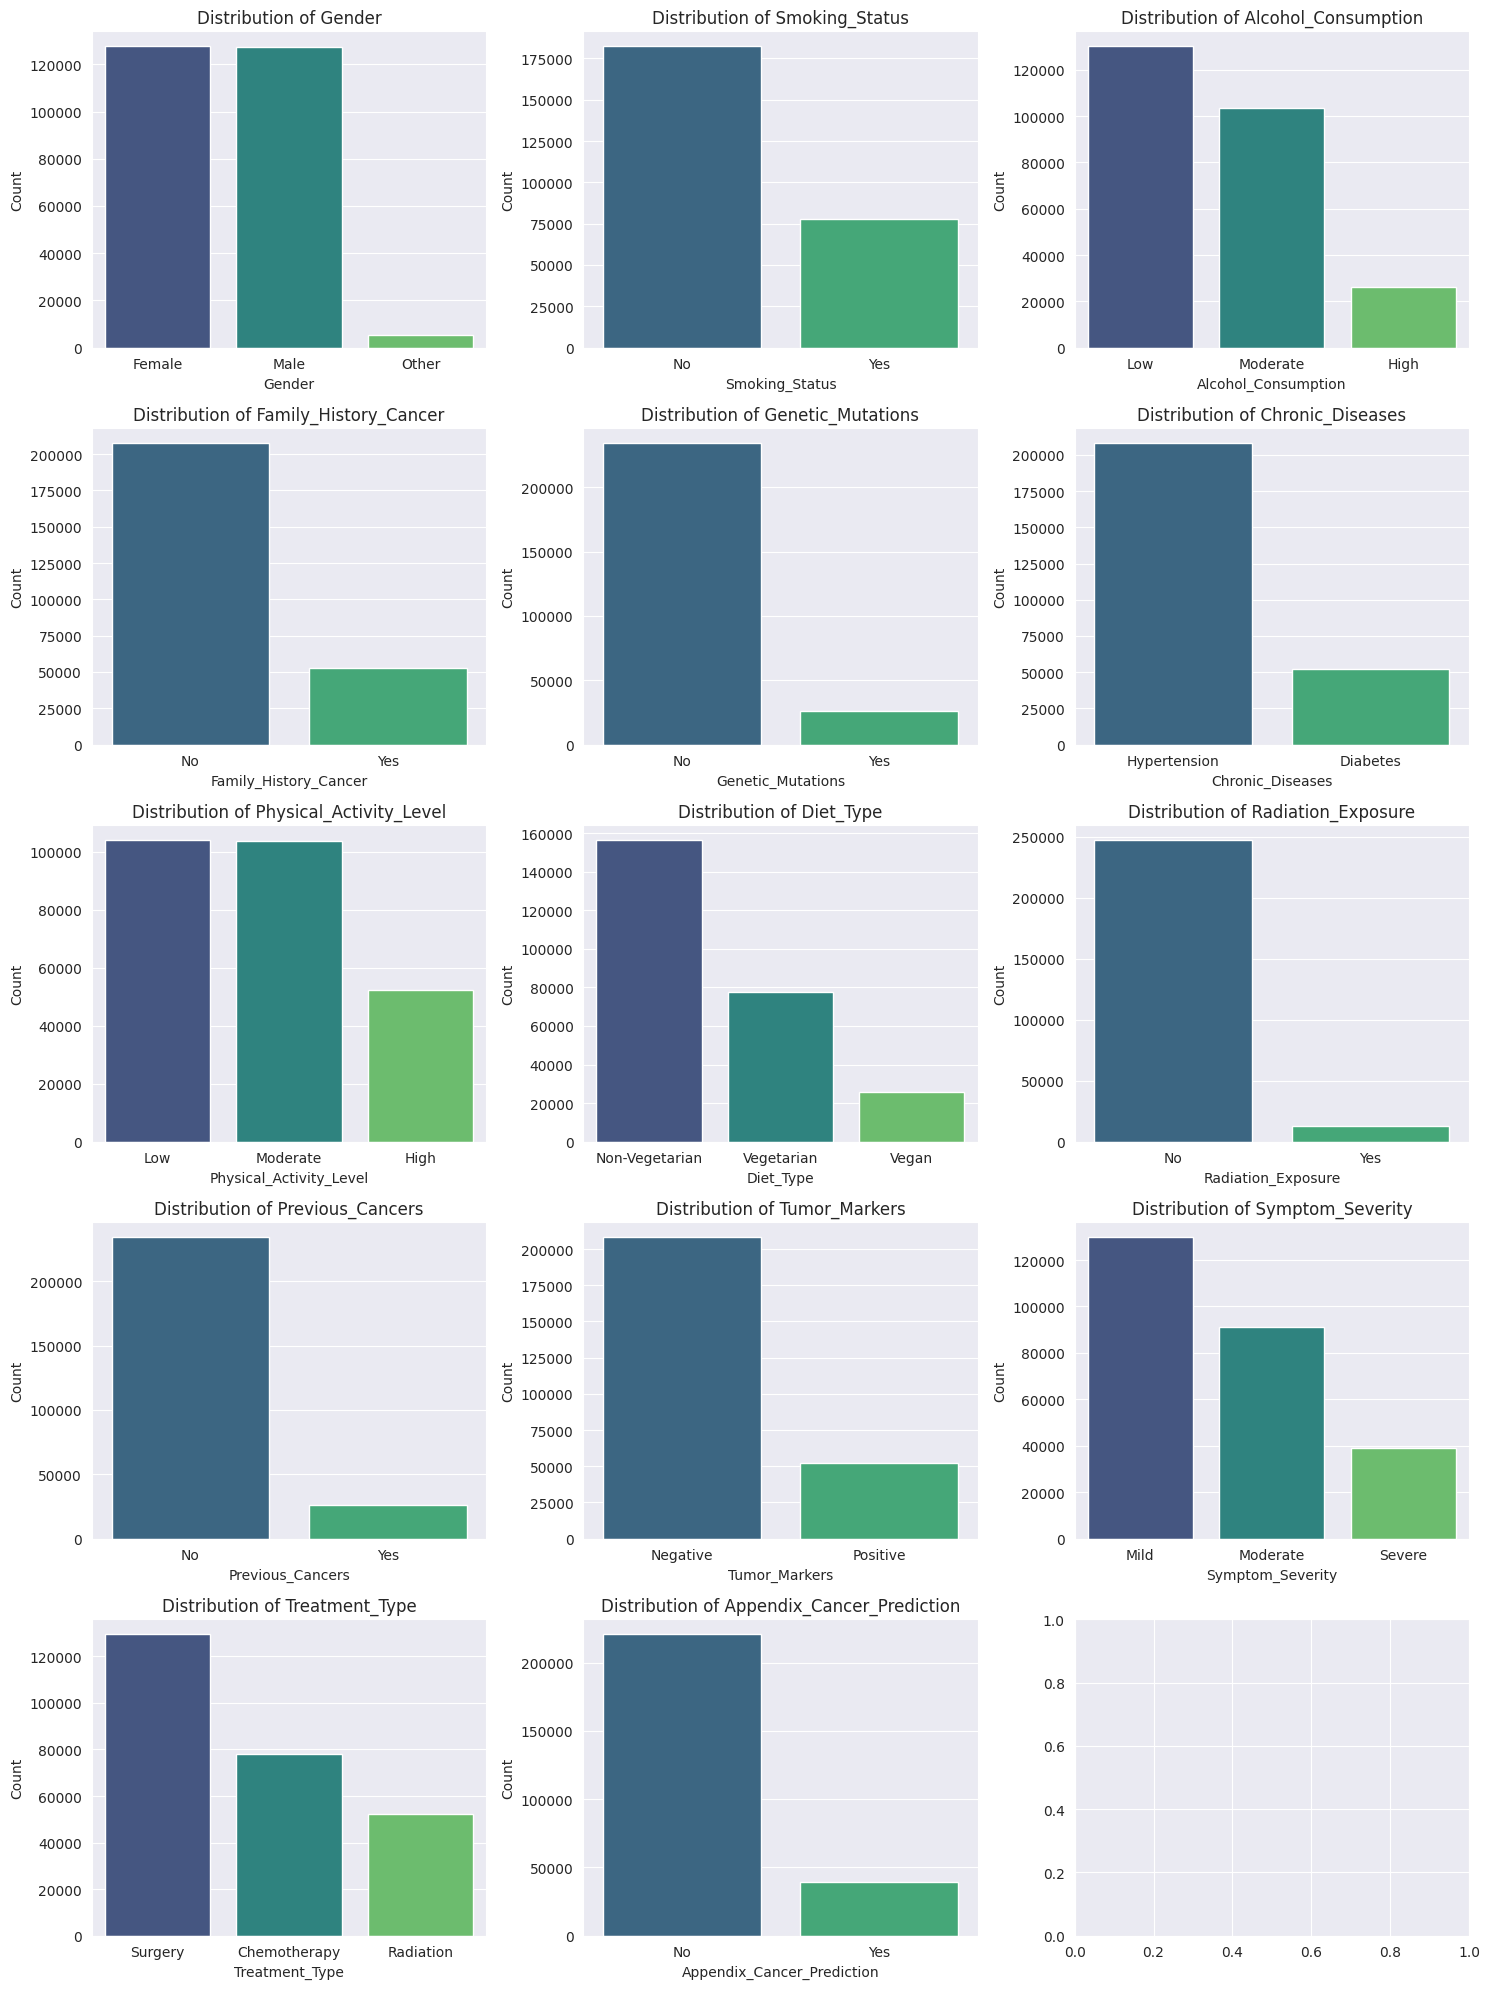

In [9]:
fig, ax = plt.subplots(5, 3, figsize=(15, 20))  # 7 rows and 2 columns of subplots
axes = ax.flatten()

# Loop over categorical columns to plot their distribution
for i, col in enumerate(categorical_features):
    sns.countplot(data=df, x=col, palette='viridis', order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [10]:
# Automatically One-Hot Encode categorical columns
df = pd.get_dummies(df, drop_first=True)  # drop_first=True prevents multicollinearity

In [11]:
df.head()

,Age,BMI,Blood_Pressure,Cholesterol_Level,White_Blood_Cell_Count,Red_Blood_Cell_Count,Platelet_Count,Diagnosis_Delay_Days,Survival_Years_After_Diagnosis,Gender_Male,...,Diet_Type_Vegan,Diet_Type_Vegetarian,Radiation_Exposure_Yes,Previous_Cancers_Yes,Tumor_Markers_Positive,Symptom_Severity_Moderate,Symptom_Severity_Severe,Treatment_Type_Radiation,Treatment_Type_Surgery,Appendix_Cancer_Prediction_Yes
0,67,28.6,156,228,8.1,4.4,361,691,6.5,False,...,False,False,False,False,False,False,False,False,True,True
1,83,19.4,117,186,9.7,6.2,235,275,1.6,False,...,False,False,False,False,False,True,False,False,False,False
2,52,17.2,115,231,8.2,4.6,269,668,0.7,False,...,False,False,False,False,False,True,False,False,False,False
3,71,31.8,149,151,6.8,6.0,193,256,2.1,True,...,False,False,False,True,False,True,False,True,False,False
4,19,17.7,179,236,6.7,4.9,396,370,0.5,False,...,False,False,False,False,False,False,False,True,False,False


In [12]:
#spliting Data
X = df.drop(columns=['Appendix_Cancer_Prediction_Yes'])
y = df['Appendix_Cancer_Prediction_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
#The model
gbm = xgb.XGBClassifier(tree_method='gpu_hist', random_state=42)

param_grid = {
'n_estimators': [50, 100],
'learning_rate': [0.01, 0.5],
'max_depth': [3, 4],
'subsample': [0.8]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_gbm_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_gbm_model.predict(X_test)

In [14]:
# Evaluate the model
print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
auc_score = roc_auc_score(y_test, y_pred)
print(f'AUC Score: {auc_score:.4f}')

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.8487
Classification Report:
              precision    recall  f1-score   support

       False       0.85      1.00      0.92     44130
        True       0.00      0.00      0.00      7870

    accuracy                           0.85     52000
   macro avg       0.42      0.50      0.46     52000
weighted avg       0.72      0.85      0.78     52000

AUC Score: 0.5000


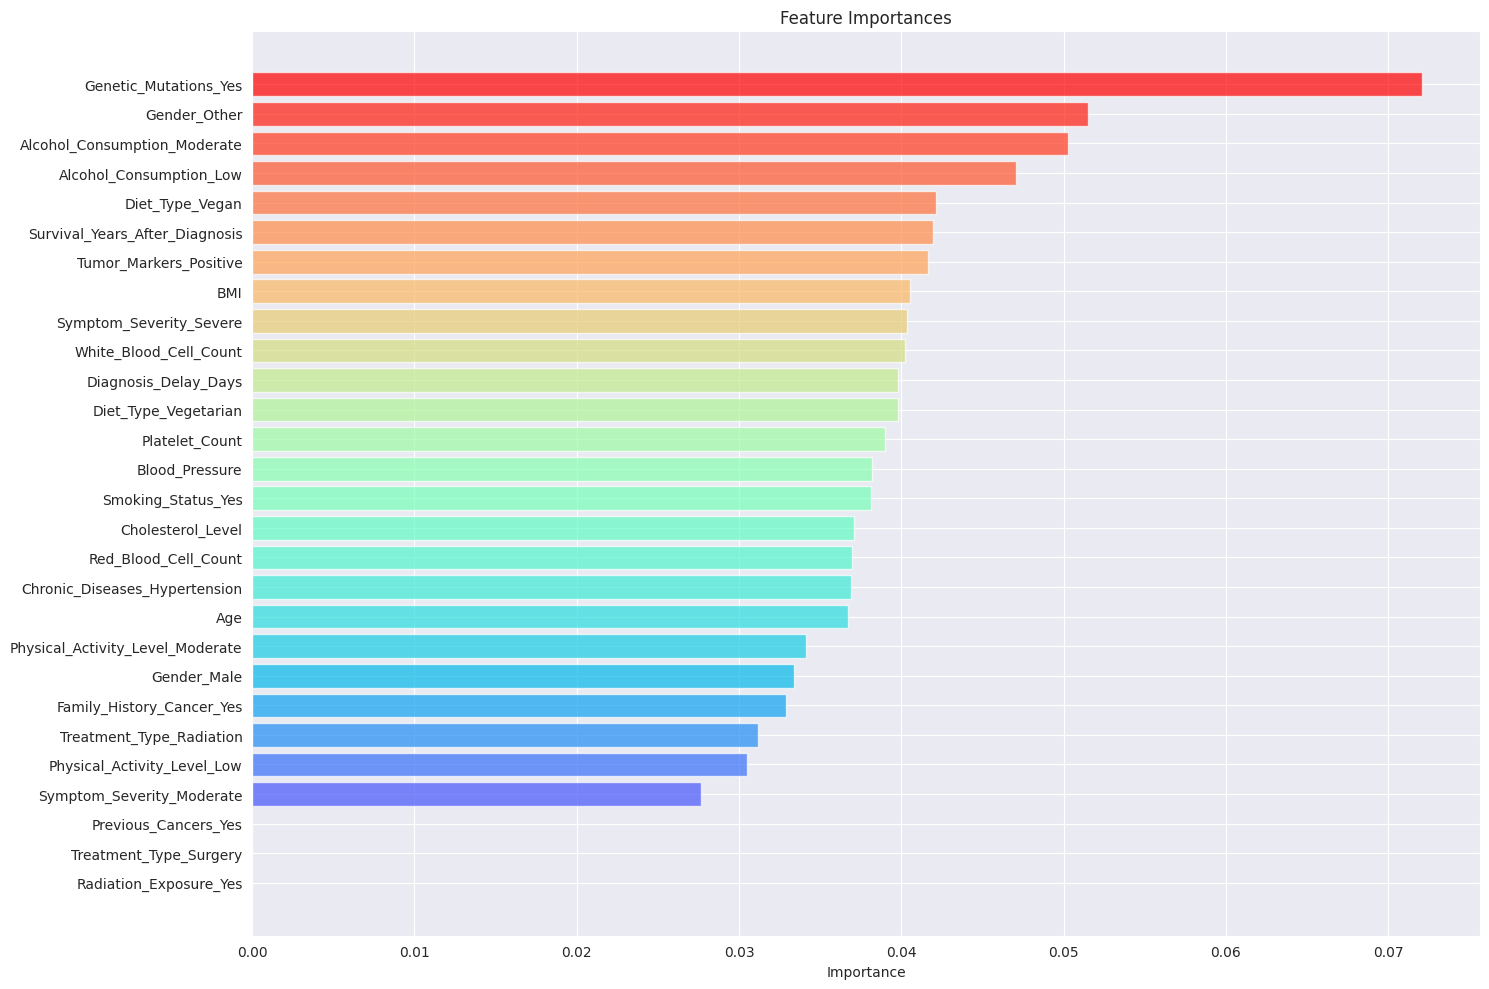

In [15]:
Feature_importances = best_gbm_model.feature_importances_
sorted_indices = np.argsort(Feature_importances)

plt.figure(figsize=(15, 10))
plt.barh(np.array(X.columns)[sorted_indices], Feature_importances[sorted_indices], color=plt.cm.rainbow(np.linspace(0, 1, len(Feature_importances))), alpha=0.7)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()